In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
# !pip show einops

In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F


In [6]:
from utils import interleave, de_interleave, show_batch, AverageMeter, show_grid, get_config
from learner import FixMatch, CoMatch, SupLearning
from dataset import get_data
from build import build_model

In [7]:
config = get_config('./configs/local_semisupervised_patho_mock.yaml')
# config = get_config('./configs/local_supervised_groupbycat.yaml')

In [8]:
# config

In [9]:
df_anno = pd.read_csv(config['DATA']['ANNO'])
df_unanno = None
df_anno.head()

,image,target,is_valid,is_labeled
0,lower-gi-tract/pathological-findings/polyps/37...,4,False,True
1,upper-gi-tract/pathological-findings/esophagit...,11,False,True
2,lower-gi-tract/pathological-findings/ulcerativ...,1,False,True
3,lower-gi-tract/pathological-findings/ulcerativ...,6,False,True
4,upper-gi-tract/pathological-findings/esophagit...,11,False,True


In [10]:
# df_anno['is_valid']

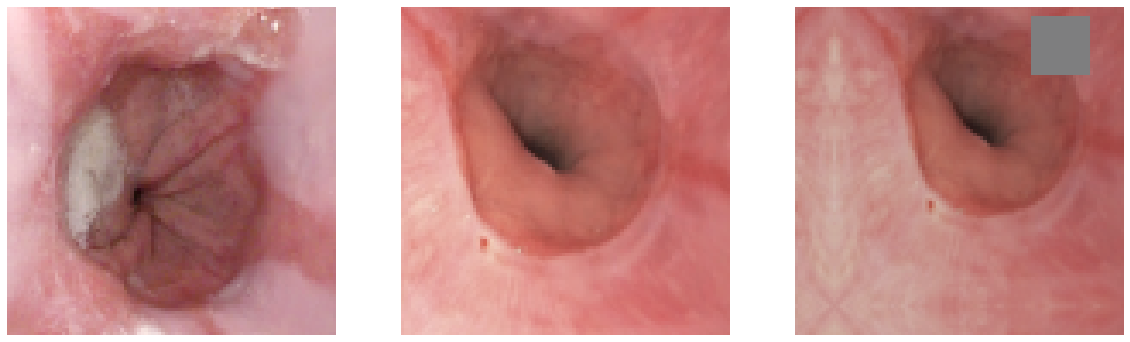

In [11]:
train_dl, valid_dl = get_data(config, df_anno, df_unanno,is_full_sup = False, is_visual=True, type_semi = 'CoMatch')

In [27]:
train_dl[1].dataset.df.sample(17*16*6)

,image,target,is_valid,is_labeled
1757,lower-gi-tract/pathological-findings/ulcerativ...,6,False,False
437,lower-gi-tract/pathological-findings/ulcerativ...,1,False,False
1468,upper-gi-tract/pathological-findings/esophagit...,11,False,False
1797,lower-gi-tract/pathological-findings/polyps/fc...,4,False,False
1533,lower-gi-tract/pathological-findings/ulcerativ...,6,False,False
...,...,...,...,...
796,lower-gi-tract/pathological-findings/polyps/76...,4,False,False
1882,lower-gi-tract/pathological-findings/ulcerativ...,6,False,False
869,lower-gi-tract/pathological-findings/ulcerativ...,6,False,False
1244,lower-gi-tract/pathological-findings/ulcerativ...,6,False,False


In [25]:
1690%(16*6)

58

In [26]:
1690//(16*6)

17

In [12]:
model = build_model(config)

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
if config.TRAIN.IS_SSL:
    if config.MODEL.TYPE_SEMI == 'FixMatch':
        classifier = FixMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
    else:
        classifier = CoMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
else:
    classifier = SupLearning(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
classifier.get_dataloader(train_dl, valid_dl)
classifier.get_config(config)

In [15]:
# classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\sup_resnet50\\05_31_2022_17_33_39_ce.pth')

In [16]:
# classifier.fit()

In [17]:
# classifier.save_checkpoint('./')

In [18]:
35*16

560